Modèle Logistic Regression (avec réduction de dimension avant PCA ou SVD)

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression

# 1⃣ Charger les datasets
train_df = pd.read_csv("/Users/konstantinganz/Library/CloudStorage/OneDrive-Personnel/Documents/Konstantin/CS/S8 Hong Kong/Cours/Stat ML/Projet_1/kaggle_statml_housing_credit/data/home-credit-default-risk/application_train_final.csv")
test_df = pd.read_csv("/Users/konstantinganz/Library/CloudStorage/OneDrive-Personnel/Documents/Konstantin/CS/S8 Hong Kong/Cours/Stat ML/Projet_1/kaggle_statml_housing_credit/data/home-credit-default-risk/application_test_final.csv")

# 2⃣ Séparer features et cible
X_train = train_df.drop(columns=["TARGET", "SK_ID_CURR"])
y_train = train_df["TARGET"]
X_test = test_df.drop(columns=["SK_ID_CURR"])

# 3⃣ Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4⃣ PCA (réduction de dimension)
pca = PCA(n_components=0.95)  # Garde 95% de la variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 5⃣ SVD (alternative pour sparse data)
svd = TruncatedSVD(n_components=50)  # On réduit à 50 dimensions
X_train_svd = svd.fit_transform(X_train_scaled)
X_test_svd = svd.transform(X_test_scaled)

# 6⃣ Entraînement Logistic Regression (Baseline, PCA, SVD)
models = {
    "Baseline": (X_train_scaled, X_test_scaled),
    "PCA": (X_train_pca, X_test_pca),
    "SVD": (X_train_svd, X_test_svd)
}

submissions = {}

for name, (X_train_model, X_test_model) in models.items():
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_model, y_train)
    
    y_pred_proba = model.predict_proba(X_test_model)[:, 1]
    
    # Stocker les prédictions
    submissions[name] = pd.DataFrame({"SK_ID_CURR": test_df["SK_ID_CURR"], "TARGET": y_pred_proba})
    submissions[name].to_csv(f"/Users/konstantinganz/Library/CloudStorage/OneDrive-Personnel/Documents/Konstantin/CS/S8 Hong Kong/Cours/Stat ML/Projet_1/kaggle_statml_housing_credit/results/submission_logistic_regression_{name}.csv", index=False)
    
    print(f"{name} - Prédictions sauvegardées.")

Baseline - Prédictions sauvegardées.
PCA - Prédictions sauvegardées.
SVD - Prédictions sauvegardées.


Modèle Random Forest

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Charger les datasets
train_df = pd.read_csv("/Users/konstantinganz/Library/CloudStorage/OneDrive-Personnel/Documents/Konstantin/CS/S8 Hong Kong/Cours/Stat ML/Projet_1/kaggle_statml_housing_credit/data/home-credit-default-risk/application_train_final.csv")
test_df = pd.read_csv("/Users/konstantinganz/Library/CloudStorage/OneDrive-Personnel/Documents/Konstantin/CS/S8 Hong Kong/Cours/Stat ML/Projet_1/kaggle_statml_housing_credit/data/home-credit-default-risk/application_test_final.csv")

# Séparer features et cible
X_train = train_df.drop(columns=["TARGET", "SK_ID_CURR"])
y_train = train_df["TARGET"]
X_test = test_df.drop(columns=["SK_ID_CURR"])

# Entraînement du modèle Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,  # Nombre d'arbres (à ajuster)
    max_depth=10,  # Profondeur max (évite overfitting)
    random_state=42,
    n_jobs=-1,  # Utilise tous les CPU pour accélérer
    class_weight="balanced"  # Gère le déséquilibre des classes
)

rf_model.fit(X_train, y_train)

# Prédictions sur application_test
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

#Génération du fichier de soumission
submission_rf = pd.DataFrame({"SK_ID_CURR": test_df["SK_ID_CURR"], "TARGET": y_pred_proba})
submission_rf.to_csv("/Users/konstantinganz/Library/CloudStorage/OneDrive-Personnel/Documents/Konstantin/CS/S8 Hong Kong/Cours/Stat ML/Projet_1/kaggle_statml_housing_credit/results/submission_RandomForest.csv", index=False)

print("✅ Random Forest - Prédictions sauvegardées.")


✅ Random Forest - Prédictions sauvegardées.


Modèle XGBOOST

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# 1️⃣ Charger les datasets
train_df = pd.read_csv("/Users/konstantinganz/Library/CloudStorage/OneDrive-Personnel/Documents/Konstantin/CS/S8 Hong Kong/Cours/Stat ML/Projet_1/kaggle_statml_housing_credit/data/home-credit-default-risk/application_train_final.csv")
test_df = pd.read_csv("/Users/konstantinganz/Library/CloudStorage/OneDrive-Personnel/Documents/Konstantin/CS/S8 Hong Kong/Cours/Stat ML/Projet_1/kaggle_statml_housing_credit/data/home-credit-default-risk/application_test_final.csv")

# 2️⃣ Séparer features et cible
X_train = train_df.drop(columns=["TARGET", "SK_ID_CURR"])
y_train = train_df["TARGET"]
X_test = test_df.drop(columns=["SK_ID_CURR"])

# 3️⃣ Configuration de XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=500,  # Nombre d'arbres
    learning_rate=0.05,  # Vitesse d'apprentissage
    max_depth=6,  # Profondeur des arbres
    subsample=0.8,  # Échantillonnage des données pour éviter l'overfitting
    colsample_bytree=0.8,  # Échantillonnage des features pour chaque arbre
    objective="binary:logistic",  # Problème de classification binaire
    eval_metric="auc",  # Optimisation du ROC-AUC
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1  # Utilise tous les CPU
)

# 4️⃣ Entraînement du modèle
xgb_model.fit(X_train, y_train)

# 5️⃣ Prédictions sur application_test
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# 6️⃣ Génération du fichier de soumission
submission_xgb = pd.DataFrame({"SK_ID_CURR": test_df["SK_ID_CURR"], "TARGET": y_pred_proba})
submission_xgb.to_csv("/Users/konstantinganz/Library/CloudStorage/OneDrive-Personnel/Documents/Konstantin/CS/S8 Hong Kong/Cours/Stat ML/Projet_1/kaggle_statml_housing_credit/results/submission_XGBoost.csv", index=False)

print("✅ XGBoost - Prédictions sauvegardées.")


/Users/konstantinganz/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [18:32:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ XGBoost - Prédictions sauvegardées.


Modèle FNN

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# 1️⃣ Charger les datasets
train_df = pd.read_csv("/Users/konstantinganz/Library/CloudStorage/OneDrive-Personnel/Documents/Konstantin/CS/S8 Hong Kong/Cours/Stat ML/Projet_1/kaggle_statml_housing_credit/data/home-credit-default-risk/application_train_final.csv")
test_df = pd.read_csv("/Users/konstantinganz/Library/CloudStorage/OneDrive-Personnel/Documents/Konstantin/CS/S8 Hong Kong/Cours/Stat ML/Projet_1/kaggle_statml_housing_credit/data/home-credit-default-risk/application_test_final.csv")

# 2️⃣ Séparer features et labels
X_train = train_df.drop(columns=["TARGET", "SK_ID_CURR"])
y_train = train_df["TARGET"].values
X_test = test_df.drop(columns=["SK_ID_CURR"])

# 3️⃣ Normalisation (important pour les réseaux de neurones)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4️⃣ Conversion en Tensors PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape pour BCE Loss
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# 5️⃣ Création du DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

# 6️⃣ Définition du MLP (FNN)
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),  # Evite l’overfitting
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 1),
            nn.Sigmoid()  # Probabilité entre 0 et 1
        )

    def forward(self, x):
        return self.model(x)

# 7️⃣ Initialisation du modèle
input_dim = X_train.shape[1]
model = MLP(input_dim)

# 8️⃣ Définition de la Loss et de l’Optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 9️⃣ Entraînement du modèle
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# 🔟 Prédictions sur les données de test
model.eval()
with torch.no_grad():
    y_pred_proba = model(X_test_tensor.to(device)).cpu().numpy()

# 🔥 Sauvegarde du fichier de soumission
submission_nn = pd.DataFrame({"SK_ID_CURR": test_df["SK_ID_CURR"], "TARGET": y_pred_proba.flatten()})
submission_nn.to_csv("/Users/konstantinganz/Library/CloudStorage/OneDrive-Personnel/Documents/Konstantin/CS/S8 Hong Kong/Cours/Stat ML/Projet_1/kaggle_statml_housing_credit/results/submission_NN.csv", index=False)

print("✅ Réseau de Neurones - Prédictions sauvegardées !")


Graphe Score Kaggle

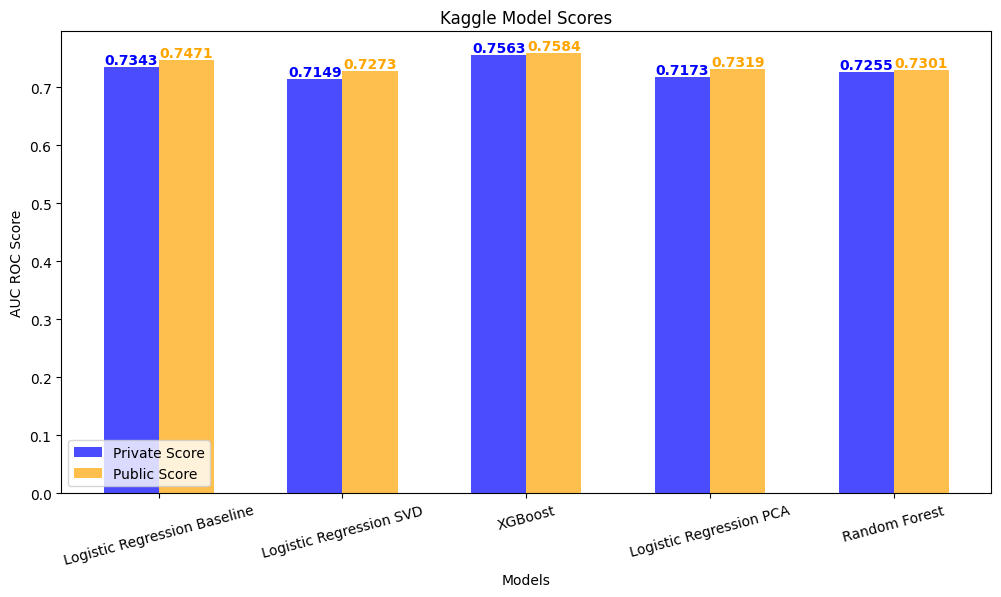

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = [
    "Logistic Regression Baseline",
    "Logistic Regression SVD",
    "XGBoost",
    "Logistic Regression PCA",
    "Random Forest"
]

# Private and public scores
private_scores = [0.73431, 0.71490, 0.75635, 0.71732, 0.72554]
public_scores = [0.74713, 0.72734, 0.75839, 0.73188, 0.73012]

# Position of the bars
x = np.arange(len(models))
width = 0.3  # Width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, private_scores, width, label="Private Score", color="blue", alpha=0.7)
bars2 = ax.bar(x + width/2, public_scores, width, label="Public Score", color="orange", alpha=0.7)

# Add scores above the bars
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.4f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='blue')

for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.4f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='orange')

# Add labels
ax.set_xlabel("Models")
ax.set_ylabel("AUC ROC Score")
ax.set_title("Kaggle Model Scores")
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.legend()

# Display the plot
plt.show()
